# Agristats preprocess in order to work with lighter files and right projections

### Different imports

In [1]:
import numpy as np
import geopandas
import pandas
import shapely.geometry
import matplotlib.pyplot as plt
from osgeo import osr

### Ireland map with GADM data

<Figure size 432x288 with 0 Axes>

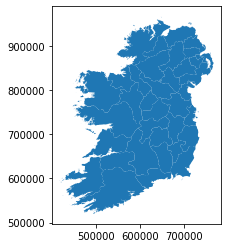

In [2]:
pandasSouth = geopandas.read_file('gadm36_IRL_1.shp')
pandasNorth = geopandas.read_file('gadm36_GBR_2.shp')

pandasSouth = geopandas.GeoDataFrame(pandasSouth, crs={'init':'epsg:4326'}, geometry='geometry')
pandasSouth = pandasSouth.to_crs({'init':'epsg:2157'})

pandasNorth = geopandas.GeoDataFrame(pandasNorth, crs={'init':'epsg:4326'}, geometry='geometry')
pandasNorth = pandasNorth.to_crs({'init':'epsg:2157'})

pandasNorth = pandasNorth.query("NAME_1 == 'Northern Ireland'")

pandasIreland = pandas.concat([pandasSouth, pandasNorth], join='inner')

plt.figure()
pandasIreland.plot()
plt.show()

### Read Agristats data from shapefile

<Figure size 432x288 with 0 Axes>

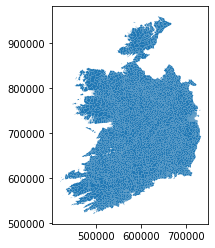

In [3]:
pandasAgristats = geopandas.read_file('HNVf-ED.shp')

# TM65 / Irish Grid, epsg:29902
# IRENET95 / Irish Transverse Mercator, epsg:2157
pandasAgristats = geopandas.GeoDataFrame(pandasAgristats, crs={'init':'epsg:29902'}, geometry='geometry')
pandasAgristats = pandasAgristats.to_crs({'init':'epsg:2157'})

plt.figure()
pandasAgristats.plot()
plt.show()

### Read quadrats data from shapefile

<Figure size 432x288 with 0 Axes>

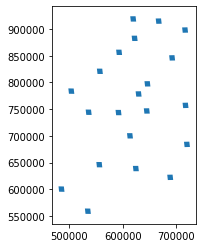

In [4]:
pandasQuadrats = geopandas.read_file('agriclimate_quadrats_Ireland.shp')

prj_file = open('agriclimate_quadrats_Ireland.prj', 'r')
prj_txt = prj_file.read()

srs = osr.SpatialReference()
srs.ImportFromESRI([prj_txt])

proj4Value = srs.ExportToProj4()

# IRENET95 / Irish Transverse Mercator, epsg:2157
pandasQuadrats = geopandas.GeoDataFrame(pandasQuadrats, crs=proj4Value, geometry='geometry')
pandasQuadrats = pandasQuadrats.to_crs({'init':'epsg:2157'})

plt.figure()
pandasQuadrats.plot()
plt.show()

### Filtering Agristats data to just keep values on quadrats

Before filtering, data had 3409 values, and 205 now.


<Figure size 432x288 with 0 Axes>

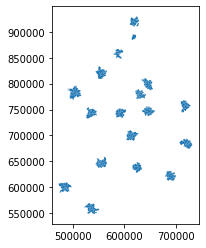

In [5]:
removeIndexes = []

for i in range (len(pandasAgristats.geometry)):
    polyAgristats = pandasAgristats.geometry[i]
    
    if any(polyAgristats.intersects(polyQuadrats) for polyQuadrats in pandasQuadrats.geometry):
        continue
    else:
        removeIndexes.append(i)

pandasFilteredAgristats = pandasAgristats.drop(removeIndexes)

print ("Before filtering, data had {} values, and {} now.".format(len(pandasAgristats), len(pandasFilteredAgristats)))

plt.figure()
pandasFilteredAgristats.plot()
plt.show()

### Save new Agristats data 

In [6]:
pandasFilteredAgristats = pandasFilteredAgristats.astype({'EDNAME': str, 'HNVf_likel': float, 'geometry': str})

pandasFilteredAgristats.to_csv('AgristatsSimplified.txt', index=False, sep=';')